# GPU vs CPU Throughput Test Result Plots

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from azure.storage.blob import BlockBlobService
import pandas as pd

## Download data from blob storage¶ 

In [2]:
ACCOUNT_NAME = 'gputestingresults'
ACCOUNT_KEY = '8blS4Dga9zf50uzYWuDPmSxz9JAX0iryZkzxAy9PqSS5jD4+YPnmmqdylJBADwPb1RADChik+esJI380cN34Qw=='

In [3]:
blob_service = BlockBlobService(account_name=ACCOUNT_NAME, account_key=ACCOUNT_KEY)

In [4]:
containers = blob_service.list_containers()
blob_list = []
container_list = []
for c in containers:
    container_list.append(c.name)
    for b in blob_service.list_blobs(c.name):
#         print(b.name)
        blob_list.append(b.name)
container_list

['results']

In [5]:
CONTAINER_NAME = container_list[0]

In [6]:
xlsx_list = [b for b in blob_list if '.xlsx' in b and 'EastUS' in b]

In [7]:
df_RPS_50 = pd.DataFrame(columns = ['Model', 'Framework', 'Cluster', 'RPS'])
for XLS_FILE in xlsx_list:
    DESTINATION_FILE = XLS_FILE.replace('GPUTesting/','')
    DESTINATION_FILE = DESTINATION_FILE.replace('EastUS_Client/','')
    DESTINATION_FILE = DESTINATION_FILE.replace('/','_')
    DESTINATION_FILE = os.path.join(os.getcwd(),DESTINATION_FILE)
    blob_service.get_blob_to_path(container_name=CONTAINER_NAME, blob_name=XLS_FILE, file_path=DESTINATION_FILE)
    df = pd.read_excel(io=DESTINATION_FILE, sheet_name='Client')
    df = df[['ThreadCount', 'AITime', 'RPS']]
    row = [DESTINATION_FILE.split('/')[3].split('_')[0], DESTINATION_FILE.split('/')[3].split('_')[2],DESTINATION_FILE.split('/')[3].split('_')[-3], float(df[df['ThreadCount']==50]['RPS'])]
    df_RPS_50.loc[len(df_RPS_50)] = row
    
#     print(DESTINATION_FILE)
#     print(df)
df_RPS_50.replace('35Pod','CPU', inplace=True )

In [8]:
df_RPS_50_pivot = pd.pivot_table(df_RPS_50, values='RPS', index=['Model', 'Framework'], columns=['Cluster'])

In [9]:
df_RPS_50_pivot

Cluster                      1GPU        2GPU        3GPU        CPU
Model        Framework                                              
MobileNet    Keras      55.122564  103.926475  141.808522  26.903556
             TF         57.126202   87.522886  116.936442        NaN
NasNetLarge  Keras       7.035507   13.816073   13.816073   2.196386
             TF         12.049442   21.804046   30.041518        NaN
NasNetMobile Keras      24.122499   41.556104   50.420629   1.887626
             TF         39.291007   73.918280   87.554202        NaN
Resnet152    Keras      13.855050   26.467655   32.887834   5.199140
             TF         18.489864   35.703668   48.897105        NaN
Resnet50     Keras      31.834873   54.944249   76.459956  12.716302
             TF         43.162852   87.276227  109.304595        NaN

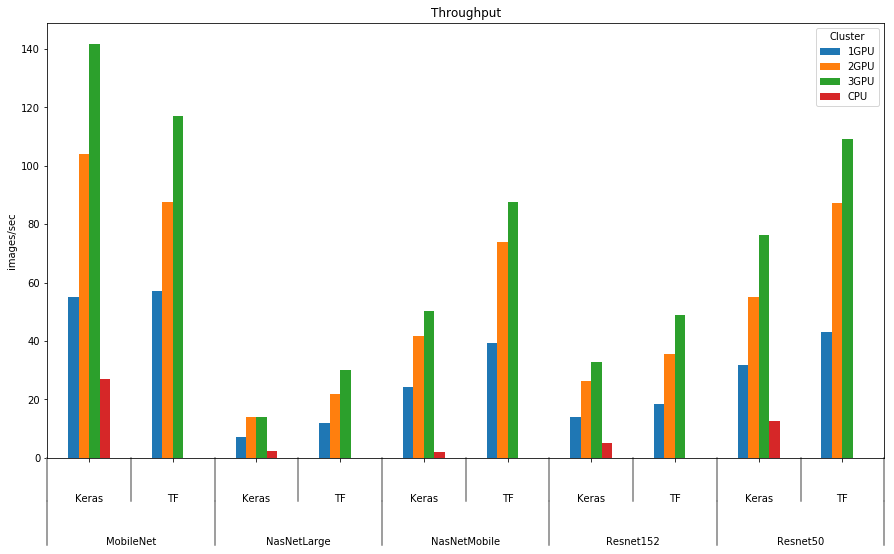

In [26]:
# referance: https://stackoverflow.com/questions/22780563/group-labels-in-matplotlib-barchart-using-pandas-multiindex

from itertools import groupby
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

# fig, ax = plt.subplots(figsize=(20, 10))
ax = df_RPS_50_pivot.plot(kind='bar',stacked=False, figsize=(15,8))
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_title('Throughput')
ax.set_ylabel('images/sec')
label_group_bar_table(ax, df_RPS_50_pivot)